## Introduction

The purpose of this notebook is to compare different **tiling-based inference approaches** for quadrat test images.
Predicting plant species directly from full high-resolution images is often challenging and leads to suboptimal performance. To address this, we explore **image tiling**, where each quadrat image is divided into smaller sub-images (tiles), species predictions are made for each tile, and the tile-level results are then aggregated to produce final image-level predictions.

In this notebook, we experiment with **multiple tiling strategies** — such as fixed-grid and adaptive tiling — and evaluate how different configurations (e.g., grid size, stride, overlap) affect prediction performance and efficiency.
The predictions are generated using a **DINOv2-based model** provided in the competition, and results are aggregated using different methods (e.g., top-k frequency, logit averaging, weighted averaging).

This notebook serves as a foundation for testing and comparing tiling and aggregation strategies to identify the most effective inference setup.

### Import libraries

In [2]:
import numpy as np 
import pandas as pd
import timm 
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import time
import os
import torchvision.transforms as T
from torch.amp import autocast
from matplotlib import pyplot as plt
from kornia import tensor_to_image
from kornia.contrib import extract_tensor_patches, compute_padding
import csv

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

class PatchDataset(Dataset):
    def __init__(self, patches, transform=None):
        self.patches = patches.squeeze(0)
        self.transform = transform

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        patch = self.patches[idx]
        
        if self.transform:
            patch = self.transform(patch)
        return patch


class TestDataset(Dataset):
    def __init__(self, image_folder, patch_size=518, stride=259, transform=None, use_pad=False):
        self.image_folder = image_folder
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]
        self.transform = transform
        self.use_pad = use_pad
        self.patch_size = patch_size
        self.stride = stride
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image).unsqueeze(0)
        
        h, w = image.shape[-2:]
        
        if self.use_pad:
            pad = compute_padding(original_size=(h, w), window_size=self.patch_size, stride=self.stride)
            patches = extract_tensor_patches(image, self.patch_size, self.stride, padding=pad)
        else:
            patches = extract_tensor_patches(image, self.patch_size, self.stride)

        return patches, image_path

In [4]:
df_species_ids = pd.read_csv('/kaggle/input/plantclef-2025/species_ids.csv')

df_metadata = pd.read_csv('/kaggle/input/plantclef-2025/PlantCLEF2024_single_plant_training_metadata.csv', sep=';', dtype={'partner': str})
class_map = df_species_ids['species_id'].to_dict() # dictionary to map the species model Id with the species Id

df_metadata.head()

image_name organ  species_id      obs_id  \
0  59feabe1c98f06e7f819f73c8246bd8f1a89556b.jpg  leaf     1396710  1008726402   
1  dc273995a89827437d447f29a52ccac86f65476e.jpg  leaf     1396710  1008724195   
2  416235e7023a4bd1513edf036b6097efc693a304.jpg  leaf     1396710  1008721908   
3  cbd18fade82c46a5c725f1f3d982174895158afc.jpg  leaf     1396710  1008699177   
4  f82c8c6d570287ebed8407cefcfcb2a51eaaf56e.jpg  leaf     1396710  1008683100   

    license partner          author  altitude   latitude  longitude  \
0  cc-by-sa     NaN   Gulyás Bálint  205.9261  47.592160  19.362895   
1  cc-by-sa     NaN    vadim sigaud  323.7520  47.906703   7.201746   
2  cc-by-sa     NaN     fil escande  101.3160  48.826774   2.352774   
3  cc-by-sa     NaN  Desiree Verver    5.1070  52.190427   6.009677   
4  cc-by-sa     NaN      branebrane  165.3390  45.794739  15.965862   

   gbif_species_id           species  genus    family   dataset publisher  \
0        5284517.0  Taxus baccata L.  Taxus  Taxaceae  plantnet  plantnet   
1        5284517.0  Taxus baccata L.  Taxus  Taxaceae  plantnet  plantnet   
2        5284517.0  Taxus baccata L.  Taxus  Taxaceae  plantnet  plantnet   
3        5284517.0  Taxus baccata L.  Taxus  Taxaceae  plantnet  plantnet   
4        5284517.0  Taxus baccata L.  Taxus  Taxaceae  plantnet  plantnet   

                                          references  \
0  https://identify.plantnet.org/fr/k-southwester...   
1  https://identify.plantnet.org/fr/k-southwester...   
2  https://identify.plantnet.org/fr/k-southwester...   
3  https://identify.plantnet.org/fr/k-southwester...   
4  https://identify.plantnet.org/fr/k-southwester...   

                                                 url learn_tag  \
0  https://bs.plantnet.org/image/o/59feabe1c98f06...     train   
1  https://bs.plantnet.org/image/o/dc273995a89827...     train   
2  https://bs.plantnet.org/image/o/416235e7023a4b...     train   
3  https://bs.plantnet.org/image/o/cbd18fade82c46...     train   
4  https://bs.plantnet.org/image/o/f82c8c6d570287...     train   

                                    image_backup_url  
0  https://lab.plantnet.org/LifeCLEF/PlantCLEF202...  
1  https://lab.plantnet.org/LifeCLEF/PlantCLEF202...  
2  https://lab.plantnet.org/LifeCLEF/PlantCLEF202...  
3  https://lab.plantnet.org/LifeCLEF/PlantCLEF202...  
4  https://lab.plantnet.org/LifeCLEF/PlantCLEF202...

In [5]:
# Auto-detect device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = timm.create_model('vit_base_patch14_reg4_dinov2.lvd142m',
                          pretrained=False,
                          num_classes=len(df_species_ids),
                          checkpoint_path='/kaggle/input/dinov2_patch14_reg4_onlyclassifier_then_all/pytorch/default/3/model_best.pth.tar')

# Move model to device
model = model.to(device)

# Set model to evaluation mode
model = model.eval()

Using device: cuda


In [6]:
data_config = timm.data.resolve_model_data_config(model)
model_input_size, model_mean, model_std = data_config['input_size'][1], data_config['mean'], data_config['std']

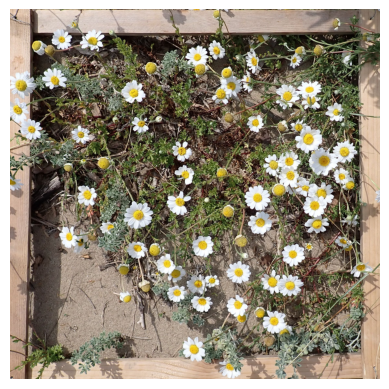

In [7]:
img = Image.open('/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/GUARDEN-CBNMed-30-4-16-3-20240428.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

## Fixed-Grid (Non-Overlapping) Tiling

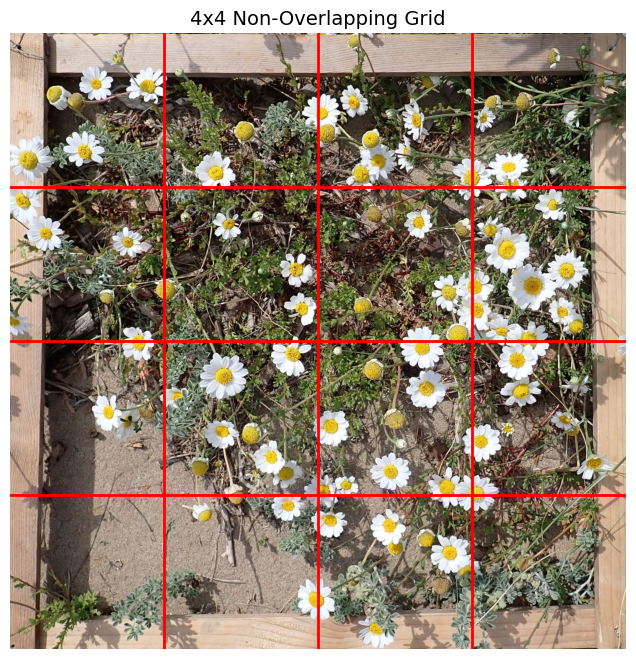

✅ Generated 16 tiles (568x568 each)


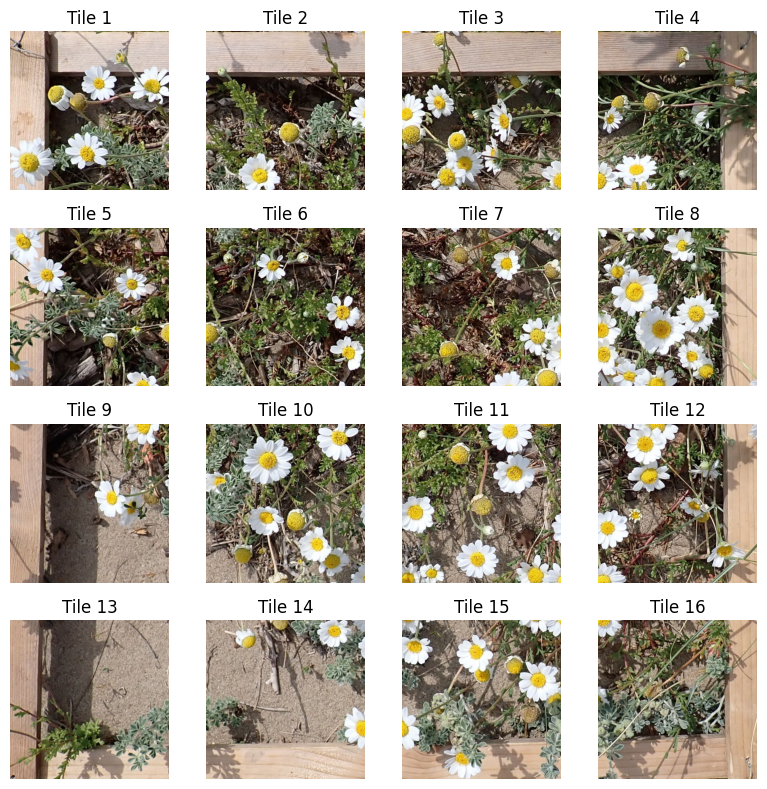

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def tile_image_fixed_grid(image, grid_size=(4, 4)):
    """
    Split image into a fixed non-overlapping grid.
    Example: grid_size=(4,4) -> 16 tiles.
    """
    width, height = image.size
    tile_w = width // grid_size[0]
    tile_h = height // grid_size[1]

    tiles = []
    for row in range(grid_size[1]):
        for col in range(grid_size[0]):
            left = col * tile_w
            upper = row * tile_h
            right = left + tile_w
            lower = upper + tile_h
            tile = image.crop((left, upper, right, lower))
            tiles.append(tile)
    return tiles, tile_w, tile_h


def visualize_grid(image, grid_size=(4, 4), save_path=None):
    """
    Visualize the non-overlapping grid over the image.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    width, height = image.size

    # Draw grid lines
    for i in range(1, grid_size[0]):
        ax.axvline(x=i * (width / grid_size[0]), color='red', linewidth=2)
    for j in range(1, grid_size[1]):
        ax.axhline(y=j * (height / grid_size[1]), color='red', linewidth=2)

    ax.set_title(f"{grid_size[0]}x{grid_size[1]} Non-Overlapping Grid", fontsize=14)
    ax.axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# Visualize the 4x4 tiling
visualize_grid(img, grid_size=(4, 4))

# Generate tiles
tiles, w, h = tile_image_fixed_grid(img, grid_size=(4, 4))
print(f"✅ Generated {len(tiles)} tiles ({w}x{h} each)")

# Optionally visualize all tiles
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(tiles[i])
    ax.axis("off")
    ax.set_title(f"Tile {i+1}")
plt.tight_layout()
plt.show()


## Sliding-Window (Overlapping) Tiling

Shape of image tiles = torch.Size([1, 64, 3, 518, 518])


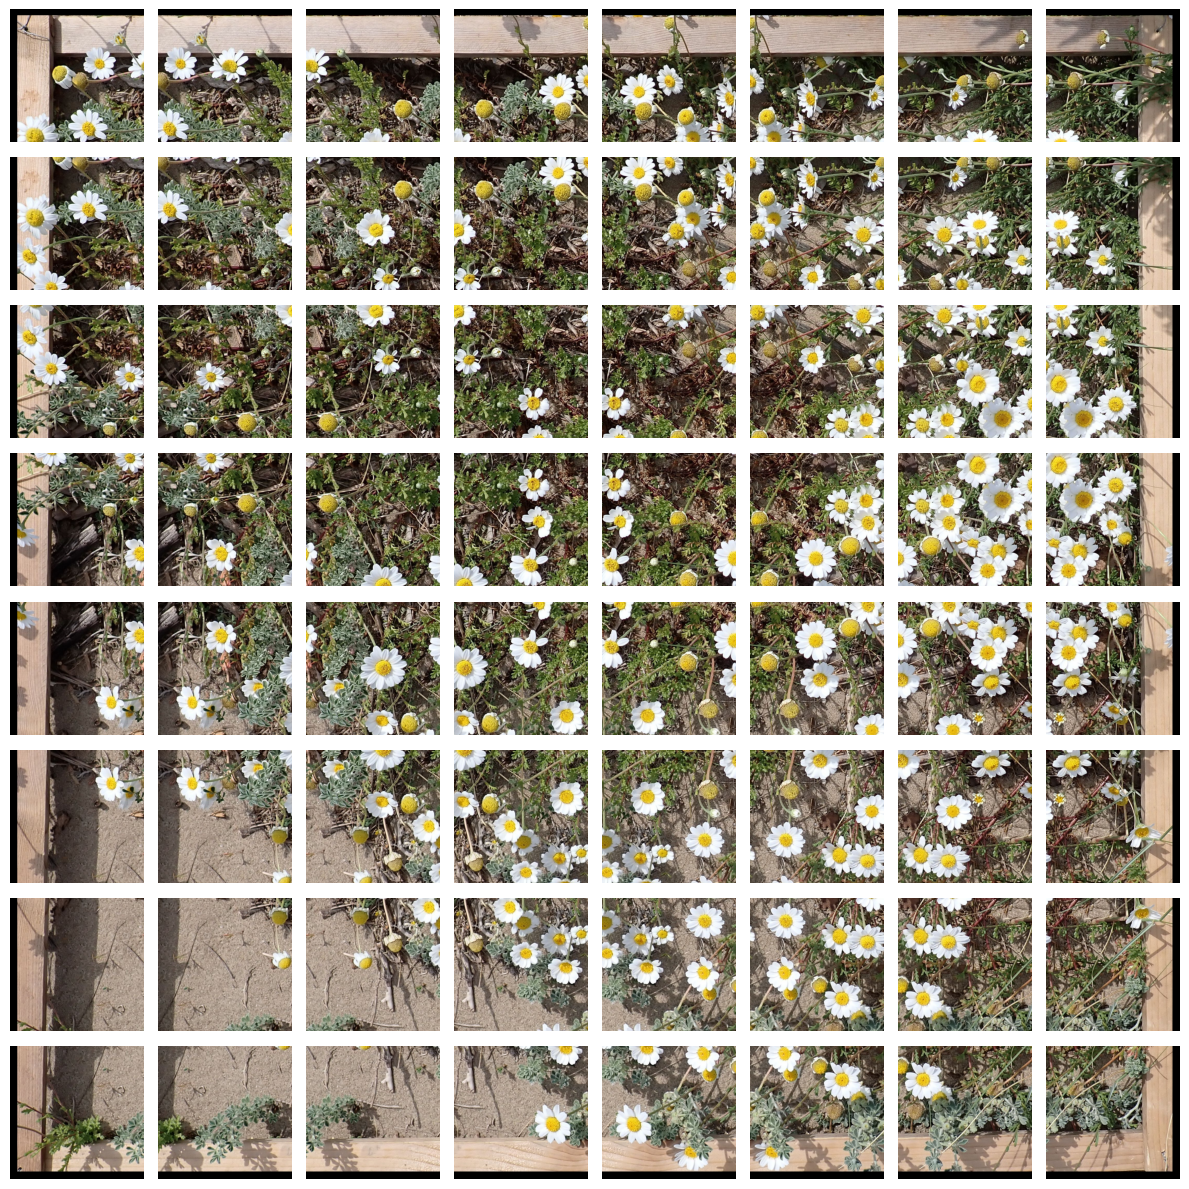

In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from kornia.contrib import extract_tensor_patches, compute_padding
from kornia import tensor_to_image

# ====== Parameters ======
patch_size = model_input_size
stride = patch_size // 2  # 50% overlap
use_pad = True #to make sure edges are included

# ====== Convert image to tensor ======
image_to_tensor = T.ToTensor()
image_tensor = image_to_tensor(img).unsqueeze(0)  # shape: [1, C, H, W]
h, w = image_tensor.shape[-2:]

# ====== Compute padding if needed ======
pad = compute_padding(original_size=(h, w), window_size=patch_size, stride=stride)

# ====== Extract patches ======
patches = extract_tensor_patches(image_tensor, patch_size, stride, padding=pad if use_pad else None)
print(f"Shape of image tiles = {patches.shape}")  # [1, num_patches, C, patch_size, patch_size]

# ====== Visualize patches ======
num_patches = patches.shape[1]
rows = int(num_patches ** 0.5)
cols = (num_patches + rows - 1) // rows  # ensures all patches fit

fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
axs = axs.ravel()

for i in range(num_patches):
    axs[i].imshow(tensor_to_image(patches[0][i]))
    axs[i].axis("off")

# Hide any unused axes
for i in range(num_patches, len(axs)):
    axs[i].axis("off")

plt.tight_layout()
plt.show()


Run over all the test dataset

In [16]:
dataset = TestDataset(image_folder='/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/',
                      patch_size=patch_size,
                      stride=stride,
                      use_pad=False,
                      transform=image_to_tensor)

In [8]:
# Define patch/stride before dataset
grid_size = 4
patch_size = model_input_size  # typically 518
stride = patch_size
image_to_tensor = T.ToTensor()

# ✅ Now create dataset
dataset = TestDataset(
    image_folder='/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/',
    patch_size=patch_size,
    stride=stride,
    use_pad=True,
    transform=image_to_tensor
)


Submit prediction

In [1]:
df_run = pd.DataFrame(list(image_predictions.items()), columns=['quadrat_id', 'species_ids'])
df_run['species_ids'] = df_run['species_ids'].apply(str)
df_run.to_csv("submission.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

NameError: name 'pd' is not defined

In [1]:
import random

# Select 5 random quadrat IDs from the image_predictions dictionary
random_quadrats = random.sample(list(image_predictions.items()), 5)

for quadrat_id, species_list in random_quadrats:
    print(f"Quadrat ID: {quadrat_id}")
    print(f"Predicted Species IDs: {species_list}")
    
    # Convert species IDs to strings
    species_list_str = [str(species_id) for species_id in species_list]
    
    # Visualize the image patch if you want to inspect the corresponding image
    image_path = os.path.join('/kaggle/input/plantclef-2025/PlantCLEF2025_test_images/PlantCLEF2025_test_images/', quadrat_id + ".jpg")
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Predictions: {', '.join(species_list_str)}")  # Join the species list as strings
    plt.show()


NameError: name 'image_predictions' is not defined

In [11]:
dataloader = DataLoader(dataset, batch_size=1, num_workers=4, pin_memory=True)

# Store per-image logits (so we can test multiple aggregations later)
image_logits = {}
batch_time = AverageMeter()
end = time.time()

with torch.no_grad():
    for batch_idx, (patches, image_path) in enumerate(dataloader):
        quadrat_id = os.path.splitext(os.path.basename(image_path[0]))[0]
        transform_patch = T.Normalize(mean=model_mean, std=model_std)
        patch_dataset = PatchDataset(patches[0], transform=transform_patch)
        patch_loader = DataLoader(patch_dataset, batch_size=256, shuffle=False)

        all_logits = []

        for batch_patches in patch_loader:
            batch_patches = batch_patches.to(device)
            with autocast('cuda'):
                outputs = model(batch_patches)  # logits
            all_logits.append(outputs.cpu())

        # Combine all logits for this image
        all_logits = torch.cat(all_logits, dim=0)  # shape: (num_tiles, num_classes)
        image_logits[quadrat_id] = all_logits

        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 10 == 0:
            print(f'Predict: [{batch_idx}/{len(dataloader)}] '
                  f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})')

# ✅ Save results to disk for later reuse
torch.save(image_logits, "image_logits.pt")
print("Saved raw logits to image_logits.pt")


Predict: [0/2105] Time 13.022 (13.022)
Predict: [10/2105] Time 5.342 (7.075)
Predict: [20/2105] Time 7.860 (6.658)
Predict: [30/2105] Time 6.644 (6.448)
Predict: [40/2105] Time 7.225 (6.320)
Predict: [50/2105] Time 2.645 (6.065)
Predict: [60/2105] Time 8.605 (6.065)
Predict: [70/2105] Time 3.457 (5.840)
Predict: [80/2105] Time 5.902 (5.897)
Predict: [90/2105] Time 6.458 (5.861)
Predict: [100/2105] Time 5.360 (5.753)
Predict: [110/2105] Time 5.949 (5.767)
Predict: [120/2105] Time 7.164 (5.802)
Predict: [130/2105] Time 3.447 (5.800)
Predict: [140/2105] Time 4.352 (5.798)
Predict: [150/2105] Time 2.644 (5.786)
Predict: [160/2105] Time 5.906 (5.805)
Predict: [170/2105] Time 6.734 (5.770)
Predict: [180/2105] Time 6.612 (5.769)
Predict: [190/2105] Time 5.320 (5.749)
Predict: [200/2105] Time 7.954 (5.786)
Predict: [210/2105] Time 6.055 (5.820)
Predict: [220/2105] Time 1.951 (5.825)
Predict: [230/2105] Time 6.111 (5.826)
Predict: [240/2105] Time 4.302 (5.828)
Predict: [250/2105] Time 5.573 (5.

In [14]:
print(type(patches[0]))


<class 'torch.Tensor'>


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Remove batch dimension if present
if patches.dim() == 5:
    patches = patches.squeeze(0)

num_patches = patches.shape[0]
rows = int(num_patches ** 0.5)
cols = (num_patches // rows) + (num_patches % rows > 0)

# Create grid for visualization
fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
axs = np.array(axs).ravel()

for i in range(num_patches):
    axs[i].imshow(patches[i].permute(1, 2, 0))  # Convert CHW → HWC
    axs[i].axis("off")

# Hide unused subplots (if any)
for i in range(num_patches, len(axs)):
    axs[i].axis("off")

plt.tight_layout()
plt.show()


NameError: name 'patches' is not defined

In [10]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=1, num_workers=4, pin_memory=True)


In [11]:
import torch
from torch.amp import autocast
import os
import time

# Store per-image logits
image_logits = {}
batch_time = AverageMeter()
end = time.time()

with torch.no_grad():
    for batch_idx, (patches, image_path) in enumerate(dataloader):
        quadrat_id = os.path.splitext(os.path.basename(image_path[0]))[0]

        transform_patch = T.Normalize(mean=model_mean, std=model_std)
        patch_dataset = PatchDataset(patches[0], transform=transform_patch)
        patch_loader = DataLoader(patch_dataset, batch_size=256, shuffle=False)

        all_logits = []

        for batch_patches in patch_loader:
            batch_patches = batch_patches.to(device)
            with autocast('cuda'):
                outputs = model(batch_patches)  # logits
            all_logits.append(outputs.cpu())

        all_logits = torch.cat(all_logits, dim=0)
        image_logits[quadrat_id] = all_logits

        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 10 == 0:
            print(f'Predict: [{batch_idx}/{len(dataloader)}] '
                  f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})')

# Save results
torch.save(image_logits, "image_logits_fixed_grid.pt")
print("✅ Saved raw logits to image_logits_fixed_grid.pt")


Predict: [0/2105] Time 5.689 (5.689)
Predict: [10/2105] Time 1.920 (2.350)
Predict: [20/2105] Time 2.182 (2.135)
Predict: [30/2105] Time 1.870 (2.043)
Predict: [40/2105] Time 2.176 (1.996)
Predict: [50/2105] Time 0.845 (1.917)
Predict: [60/2105] Time 2.546 (1.917)
Predict: [70/2105] Time 1.309 (1.849)
Predict: [80/2105] Time 1.872 (1.855)
Predict: [90/2105] Time 2.178 (1.838)
Predict: [100/2105] Time 1.877 (1.811)
Predict: [110/2105] Time 1.869 (1.814)
Predict: [120/2105] Time 2.194 (1.822)
Predict: [130/2105] Time 1.305 (1.827)
Predict: [140/2105] Time 1.305 (1.824)
Predict: [150/2105] Time 0.841 (1.821)
Predict: [160/2105] Time 1.870 (1.825)
Predict: [170/2105] Time 1.874 (1.814)
Predict: [180/2105] Time 2.186 (1.816)
Predict: [190/2105] Time 1.567 (1.807)
Predict: [200/2105] Time 2.658 (1.817)
Predict: [210/2105] Time 1.869 (1.824)
Predict: [220/2105] Time 0.842 (1.825)
Predict: [230/2105] Time 1.874 (1.824)
Predict: [240/2105] Time 1.567 (1.826)
Predict: [250/2105] Time 1.873 (1.82

In [16]:
import pandas as pd
import csv
import torch
import torch.nn.functional as F

# ----------------------------
# Load saved logits
# ----------------------------
image_logits = torch.load("image_logits_fixed_grid.pt")  # {quadrat_id: logits_tensor}

# Load species IDs
df_species_ids = pd.read_csv('/kaggle/input/plantclef-2025/species_ids.csv')
class_map = {i: sid for i, sid in enumerate(df_species_ids['species_id'].values)}

# ----------------------------
# Aggregation functions
# ----------------------------
def topk_aggregation(all_logits, top_k_tile, min_score, class_map):
    probs = F.softmax(all_logits, dim=1)
    top_probs, top_indices = torch.topk(probs, top_k_tile)
    image_results = {}
    for idx in range(top_indices.shape[0]):
        for cls_idx, prob in zip(top_indices[idx], top_probs[idx]):
            if prob > min_score:
                species_id = class_map[cls_idx.item()]
                image_results[species_id] = max(image_results.get(species_id, 0), prob.item())
    # Keep only top-N species per image
    max_species_per_image = 5
    sorted_species = sorted(image_results.items(), key=lambda x: x[1], reverse=True)
    return [cls for cls, _ in sorted_species[:max_species_per_image]]

def logit_avg_aggregation(all_logits, min_score, class_map):
    avg_logits = all_logits.mean(dim=0)
    probs = F.softmax(avg_logits, dim=0)
    image_results = {class_map[i]: p.item() for i, p in enumerate(probs) if p >= min_score}
    # Keep top-N
    max_species_per_image = 5
    sorted_species = sorted(image_results.items(), key=lambda x: x[1], reverse=True)
    return [cls for cls, _ in sorted_species[:max_species_per_image]]

def weighted_logit_avg_aggregation(all_logits, min_score, class_map):
    probs = F.softmax(all_logits, dim=1)
    weights = probs.max(dim=1).values
    weights = weights / weights.sum()
    weighted_logits = (all_logits * weights.unsqueeze(1)).sum(dim=0)
    probs = F.softmax(weighted_logits, dim=0)
    image_results = {class_map[i]: p.item() for i, p in enumerate(probs) if p >= min_score}
    # Keep top-N
    max_species_per_image = 5
    sorted_species = sorted(image_results.items(), key=lambda x: x[1], reverse=True)
    return [cls for cls, _ in sorted_species[:max_species_per_image]]

# ----------------------------
# Settings
# ----------------------------
top_k_tile = 5
min_score = 0.4

# Containers for results
preds_topk = {}
preds_logit = {}
preds_weighted = {}

# ----------------------------
# Iterate through images
# ----------------------------
print("Starting predictions...")
for i, (quadrat_id, logits) in enumerate(image_logits.items()):
    preds_topk[quadrat_id] = topk_aggregation(logits, top_k_tile, min_score, class_map)
    # Uncomment if you want to run logit averaging:
    #preds_logit[quadrat_id] = logit_avg_aggregation(logits, min_score, class_map)
    #preds_weighted[quadrat_id] = weighted_logit_avg_aggregation(logits, min_score, class_map)

    if i % 50 == 0:
        print(f"Processed {i}/{len(image_logits)} images")

# ----------------------------
# Save submission CSV
# ----------------------------
def save_submission(predictions, name):
    print("Saving CSV...")
    df_run = pd.DataFrame([
        (qid, species_ids) for qid, species_ids in predictions.items()
    ], columns=['quadrat_id', 'species_ids'])
    df_run.to_csv(f"submission_{name}.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
    print(f"✅ Saved: submission_{name}.csv")

save_submission(preds_topk, "topk")
#save_submission(preds_logit, "logit_avg")
#save_submission(preds_weighted, "weighted_logit_avg")


Starting predictions...
Processed 0/2105 images
Processed 50/2105 images
Processed 100/2105 images
Processed 150/2105 images
Processed 200/2105 images
Processed 250/2105 images
Processed 300/2105 images
Processed 350/2105 images
Processed 400/2105 images
Processed 450/2105 images
Processed 500/2105 images
Processed 550/2105 images
Processed 600/2105 images
Processed 650/2105 images
Processed 700/2105 images
Processed 750/2105 images
Processed 800/2105 images
Processed 850/2105 images
Processed 900/2105 images
Processed 950/2105 images
Processed 1000/2105 images
Processed 1050/2105 images
Processed 1100/2105 images
Processed 1150/2105 images
Processed 1200/2105 images
Processed 1250/2105 images
Processed 1300/2105 images
Processed 1350/2105 images
Processed 1400/2105 images
Processed 1450/2105 images
Processed 1500/2105 images
Processed 1550/2105 images
Processed 1600/2105 images
Processed 1650/2105 images
Processed 1700/2105 images
Processed 1750/2105 images
Processed 1800/2105 images


Evaluating thresholds...
min_score=0.01 → avg species/image: 58.44
min_score=0.11 → avg species/image: 8.14
min_score=0.21 → avg species/image: 3.58
min_score=0.31 → avg species/image: 2.05
min_score=0.41 → avg species/image: 1.29
min_score=0.50 → avg species/image: 0.84
min_score=0.60 → avg species/image: 0.57
min_score=0.70 → avg species/image: 0.38
min_score=0.80 → avg species/image: 0.22
min_score=0.90 → avg species/image: 0.10


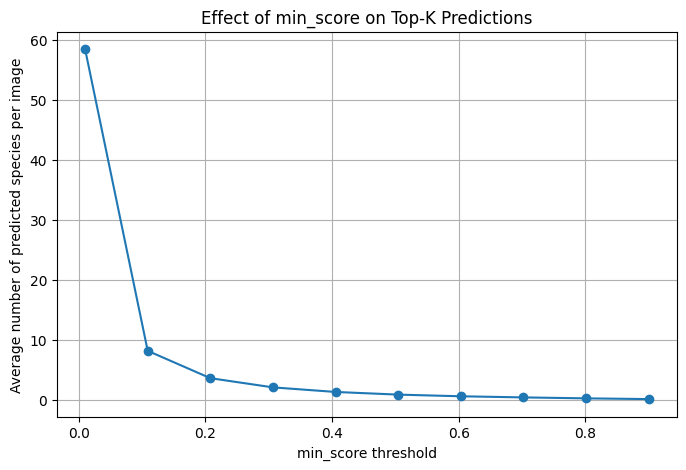

In [14]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# --- Load logits ---
image_logits = torch.load("image_logits_fixed_grid.pt")

# --- Define Top-K aggregation ---
def topk_aggregation(all_logits, top_k_tile, min_score):
    probs = F.softmax(all_logits, dim=1)
    top_probs, top_indices = torch.topk(probs, top_k_tile)
    image_results = {}
    for idx in range(top_indices.shape[0]):
        for cls, prob in zip(top_indices[idx], top_probs[idx]):
            if prob > min_score:
                image_results[cls.item()] = max(image_results.get(cls.item(), 0), prob.item())
    return list(image_results.keys())

# --- Test multiple thresholds ---
thresholds = np.linspace(0.01, 0.9, 10)  # from 0.01 to 0.9
top_k_tile = 5

avg_species_counts = []

print("Evaluating thresholds...")
for min_score in thresholds:
    species_counts = []
    for logits in image_logits.values():
        preds = topk_aggregation(logits, top_k_tile, min_score)
        species_counts.append(len(preds))
    avg_species_counts.append(np.mean(species_counts))
    print(f"min_score={min_score:.2f} → avg species/image: {np.mean(species_counts):.2f}")

# --- Plot results ---
plt.figure(figsize=(8,5))
plt.plot(thresholds, avg_species_counts, marker='o')
plt.title("Effect of min_score on Top-K Predictions")
plt.xlabel("min_score threshold")
plt.ylabel("Average number of predicted species per image")
plt.grid(True)
plt.show()
